# Introduction

While it may be a drag, you can predict the motion of objects to extreme
precision, depending on how much detail you are willing to put into your model.
In this lab, we will attempt to predict the motion of a cart under acceleration,
Primarily, we will focus on the application of our understanding of drag,
thrust, and other variable forces. We will need to apply the principal of
integration of forces to predict the kinematics of the cart, since we will be
unable to solve this analytically given that the force of the thruster will
deteriorate over time.

To find the times it takes the cart to reach certain distances after the
thruster is activated leads to the following free body diagram:

![Cart Free Body Diagram](cart_free_body.png)

This creates a differential equation for the cart's acceleration when solving
using Newton's Second Law:

$$ \frac{\mathrm{d}v}{\mathrm{d}t} = \frac{F_T(t) - \mu_r mg - \frac{1}{2}C_D
\rho A v^2}{m} $$ 

Solving this equation is unnecessary for the Python numerical approximation.
Instead of using LoggerPro, we decided to use a Matplotlib and NumPy.


In [1]:
# Imports
from math import *
from numpy import genfromtxt
from IPython.display import Video
import numpy as np
import matplotlib.pyplot as plt

# Gravity
g = 9.81 # m/s^2


# Finding Coefficient of Rolling Friction

Since we are taking air drag into account, calculating the friction coefficient
becomes more difficult. But as long as we keep the velocities low enough, drag
should not have a big impact, and can be ignored. So, since rolling friction
acts the same as kinetic friction, a previous experiment from Lab 5 can be used
where the velocities involved were quite low.

In that lab, the theta method for finding the kinetic coefficient of friction
turned out to be the most accurate method. The condition which created the
inaccuracy in the constant velocity method (the fact that the string on the cart
didn't align with its center of mass, creating a vertical component of force
affecting the normal force) is also gone. Despite this, which was why we found
the theta method to be reliable in comparison to the constant velocity method,
it still stands that the theta method can be used.

In Lab 5, to find the coefficient of friction, we released the object from rest
on a slope at an angle high enough as to exceed the static friction force
threshold and cause motion. From there, we measured the time it took to cover a
set distance and calculated the constant acceleration thereof.

![Experiment 1 Calculations](experiment_1.png)

The equations work out, where $\mu_k$ is substituted for $\mu_r$, as:

$$ \mu_r = \frac{g \sin\theta - 2xt^{-2}}{g \cos\theta} $$

Our measuements are recorded and calculated in Python, with an average of the 6
trials.


In [2]:
# Recorded data
exp1_theta = 4 # degrees
exp1_distance = 1.2 - 0.23 # meters
exp1_times = [1.89, 2.17, 2.09, 1.9, 2.14, 2.1] # from each test, in seconds

mu_r_values = (g*sin(radians(exp1_theta)) - \
    ((2*exp1_distance)/np.power(exp1_times,2))) / \
    g*cos(radians(exp1_theta))

# To be used later as well
mu_r = np.average(mu_r_values)

print(f"Coefficents of rolling friction:{mu_r_values}")
print(f"Average:{mu_r}")


Coefficents of rolling friction:[0.01435975 0.02769234 0.02442374 0.01493955 0.0265095  0.02485284]
Average:0.022129619630993542


# Finding Mass of Cart

Here, we put the cart on a force meter at rest. Then, we measured the normal
force required to keep the cart at rest, which is equal in magnitude to the
force of gravity. Since $F_G = mg$, and $|n|=|F_G|$, $m=n/g$.

In [3]:
measured_normal_force = 9.36 # N
mass = measured_normal_force / g # kg
print(f"Mass: {mass} kg")

Mass: 0.9541284403669724 kg


# Finding Drag Parameters

Measuring the cross-sectional area of the cart is easy, but not so much
measuring $C_D$ and $\rho$. Of course, all the parameters really turn into a
*single* coefficient, but measuring them separately doesn't hurt.

First, to measure $\rho$, we need three unknowns: air pressure, temperature, and
the relative humidity. These are simply taken from the day's weather forecast
and plugged into the equation. We calculate the density of humid air as a
mixture of ideal gases using the ideal gas equation, with the molar mass of
water vapor $M_v$, dry air $M_d$, and the universal gas constant $R$ given.

$$ \rho_{air} = \frac{p_d M_d + p_v M_v}{RT} $$

Since $p_d + p_v = p$ (partial pressure) where $p$ is the observed total air
pressure, which is gathered like temperature and relative humidity from the
day's weather forecast, all that we need to calculate $p_d$ is $p_v$. It is
given by $p_v=\phi p_{sat}$ where $\phi$ is the relative humidity ratio and
$p_{sat}$ is the saturation vapor pressure. Tetens' equation can be used to
calculate this:

$$ p_{sat}=0.61078\,\exp{\left(\frac{17.27T}{T+237.3}\right)} $$

The temperature here is in Celsius, unlike the previous equation where it is in
Kelvins. The pressure in this equation is also in kPa unlike the previous one in
Pa. This is coded in Python with the day's forecast included in the
calculations.



In [4]:
# Constants
uni_gas_cons = 8.31446 # J/K mol
mol_mass_dry_air = 0.028965 # kg/mol
mol_mass_vapor = 0.018016 # kg/mol

forecast_temp = 20 # celsius (actually just the termostat temp)
forecast_temp_k = forecast_temp + 273.15 # kelvins

# Since we are indoors, this is a educated guess, as the forecast corcens the
# relative humidity outside
forecast_rel_humid = 0

forecast_pressure = 29.96 # inHg
forecast_pressure_pa = forecast_pressure / 0.00029530 # Pa

pressure_sat = 0.61078 * (e**((17.27*forecast_temp)/(forecast_temp + 237.3))) # kPa
pressure_vapor = forecast_rel_humid*pressure_sat*1000 # Pa
pressure_dry_air = forecast_pressure_pa - pressure_vapor # Pa

rho = (mol_mass_dry_air*pressure_dry_air + mol_mass_vapor*pressure_vapor) \
    / (uni_gas_cons*forecast_temp_k) # kg/m^3

print(f"Air density: {rho} kg/m^3")

Air density: 1.2056685933911813 kg/m^3


Next, just the cross-sectional area, measured by hand.

In [5]:
area = 0.038 * 0.086 # m^2
print(f"Area: {area} m^2")

Area: 0.0032679999999999996 m^2


And finally, to measure $C_D$, we decided to place a fan in front of the cart.
Given the known velocity of air around the cart, all that becomes necessary to
measure the coefficients is the actual drag force. So we locked the cart in
place with a force sensor and measured the net force exerted by the cart on the
force sensor.

![Experiment 3 Calculations](experiment_3.png)


In [6]:
measured_drag_force = 0.07 # N
measured_fan_air_speed = 11.9 # m/s

drag_coefficent = (2*measured_drag_force)/(rho*area*(measured_fan_air_speed**2)) # dimensionless
print(f"Drag coefficent: {drag_coefficent}")

Drag coefficent: 0.2509135511307979


# Cart Estimations

Using the parameters found and the data given on the thruster's force, we can
calculate some estimations of the position of the cart at any given time after
the thruster turns on. This is done by numerically integrating the equation for
the total acceleration of the cart, as found above, twice to get the position of
the cart at any given time.


Time to reach 0.5 m: 0.433 seconds
Time to reach 1.0 m: 0.637 seconds
Time to reach 2.0 m: 0.947 seconds


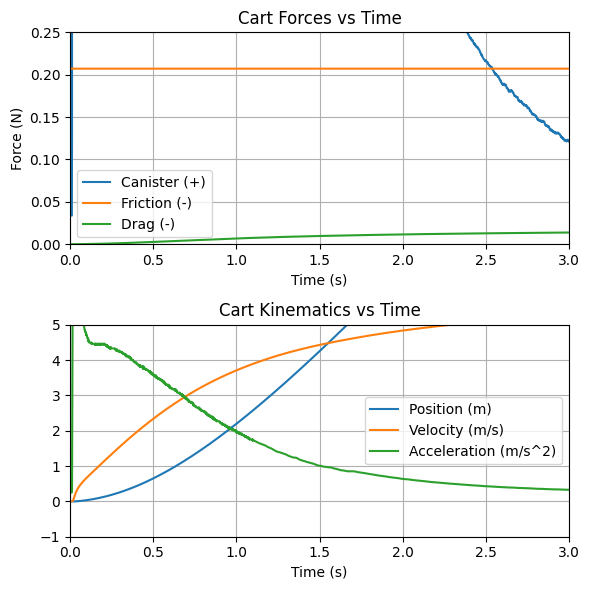

In [7]:
# Loading CO2 canister data
canister_data = genfromtxt("co2_data.csv", delimiter=",", names=True)
time = canister_data["Time_s"] # s
canister_force = canister_data["Force_N"] # N

# Constant force
friction = mu_r*mass*g

# Sets up arrays for real values
size = np.size(time)
drag = np.zeros(size)
position = np.zeros(size)
velocity = np.zeros(size)
acceleration = np.zeros(size)

# Numerical integration required for differential equation
for i in range(0, size):
    # First, calculate the new velocity required by the drag force equation
    # (where i = 0, the index is -1, but this is just 0 so it doesn't matter)
    # (divide by 1000 since the time interval is 0.001 second)
    velocity[i] = velocity[i-1] + (acceleration[i-1]/1000)
    # Second, calculate the drag force
    drag[i] = 0.5*drag_coefficent*rho*area*(velocity[i]**2)
    # Third, find sum of forces in the x-direction and find acceleration
    sum_forces = canister_force[i] - drag[i] + friction
    acceleration[i] = (sum_forces)/mass
    # The edge case, where the velocity is zero, which applies to the rolling
    # friction, is ignored, since it does not appear within the time range of
    # the cart's motion given its low rolling friction

# Easy numerical integration
position = np.cumsum(velocity) / 1000

fig, (ax1, ax2) = plt.subplots(2, figsize=(6,6))

# Plot forces
ax1.plot(time, canister_force, label="Canister (+)")
ax1.plot(time, np.ones(size)*friction, label="Friction (-)")
ax1.plot(time, drag, label="Drag (-)")
ax1.set_xlabel("Time (s)")
ax1.set_xlim([0,3])
ax1.set_ylabel("Force (N)")
ax1.set_ylim([0,0.25])
ax1.set_title("Cart Forces vs Time")
ax1.legend()
ax1.grid()

# Plot kinematics
ax2.plot(time, position, label="Position (m)")
ax2.plot(time, velocity, label="Velocity (m/s)")
ax2.plot(time, acceleration, label="Acceleration (m/s^2)")
ax2.set_title("Cart Kinematics vs Time")
ax2.set_xlabel("Time (s)")
ax2.set_xlim([0,3])
ax2.set_ylim([-1,5])
ax2.legend()
ax2.grid()

fig.tight_layout()

# Values needed for lab
t1 = time[np.argmax(position > 0.5)]
t2 = time[np.argmax(position > 1.0)]
t3 = time[np.argmax(position > 2)]

print(f"Time to reach 0.5 m: {t1} seconds")
print(f"Time to reach 1.0 m: {t2} seconds")
print(f"Time to reach 2.0 m: {t3} seconds")


# Actual Cart Results

In [8]:
# Actual cart results
actual_t1 = 0.03469 # s
actual_t2 = 0.26161 # s
actual_t3 = 0.69886 # s

# Actual cart results (slow mo)
actual_t1_sm = 0.205 # s
actual_t2_sm = 0.2197 # s
actual_t3_sm = 0.242 # s

print("Difference is estimate minus actual value")
print(f"Difference 0.5 m: {t1-actual_t1} seconds")
print(f"Difference 0.5 m: {t2-actual_t2} seconds")
print(f"Difference 0.5 m: {t3-actual_t3} seconds")
print("\nDifference is estimate minus actual value (slow mo)")
print(f"Difference 0.5 m: {t1-actual_t1_sm} seconds")
print(f"Difference 0.5 m: {t2-actual_t2_sm} seconds")
print(f"Difference 0.5 m: {t3-actual_t3_sm} seconds")

Difference is estimate minus actual value
Difference 0.5 m: 0.39831 seconds
Difference 0.5 m: 0.37539 seconds
Difference 0.5 m: 0.24813999999999992 seconds

Difference is estimate minus actual value (slow mo)
Difference 0.5 m: 0.228 seconds
Difference 0.5 m: 0.4173 seconds
Difference 0.5 m: 0.705 seconds


In [9]:
# PDF videos
Video('close_up.mp4')


In [10]:
# PDF videos
Video('full.mov')


# Analysis

In the close up video (which sadly can not be embedded in the PDF; it is
attached to the Canvas submission), you can notice the canister shoots backwards
shortly after being triggered. We estimate that this action impacted the
acceleration by some amount. It is also apparent that the C02 gas, expelled from
the canister, rebounds against the back of the cart, adding to the total
acceleration caused by the canister. The full video has different time values
farther from our estimations than the photogates themselves. This may be because
of human error in either one of the methods to measure the cart's timings.

# Conclusion

In this lab, we successfully used our understandings of thrust, drag, and other
variable forces to predict the kinematics of a moving cart. We learned numerical
integration using Python. Calculating the effects that forces have on objects is
essential to engineering. For example, calculating the forces of drag on an
aircraft.

